In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Logistic Regression library
from sklearn.linear_model import LogisticRegression

# Libraries to scale the data
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler

# Cross Validation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.decomposition import PCA

# Bayesian Optimization libraries
from functools import partial
from skopt import gp_minimize
from skopt import space
from sklearn import model_selection

# Performance Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Ignores runtime warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

%matplotlib inline

### Analysis on K-means Imputed and Outlier Presence dataset

In [2]:
df1 = pd.read_csv("./data_with_outliers_kmeans_imputed.csv")

In [3]:
df1.head()

Unnamed: 0  age_ma  Feature     Ti     La     Ce     Pr      Nd     Sm  \
0           0   222.0      0.0   7.88   0.05   10.5   0.05    4.25  11.60   
1           1   222.0      0.0  10.90  69.10  169.0  22.50  132.00  41.80   
2           2   222.0      0.0   6.00   0.02   25.1   0.30    4.41  13.80   
3           3   222.0      0.0   9.06   0.28   12.0   0.07    1.88   5.08   
4           4   222.0      0.0   4.93   0.07   16.5   0.15    2.32   8.23   

     Eu  ...     Dy     Ho     Er     Tm      Yb     Lu       Y       Hf  \
0  1.99  ...  295.0  125.0  526.0  129.0  1077.0  199.0  2737.0  12390.0   
1  4.34  ...  361.0  147.0  611.0  148.0  1232.0  228.0  3226.0  12591.0   
2  2.30  ...  415.0  172.0  701.0  167.0  1358.0  248.0  3675.0  12724.0   
3  1.01  ...  194.0   83.0  356.0   89.5   762.0  144.0  1832.0  12894.0   
4  1.52  ...  257.0  108.0  456.0  111.0   936.0  171.0  2355.0  12535.0   

       U     Th  
0  305.0  134.0  
1  503.0  272.0  
2  639.0  414.0  
3  308.0  127.0  
4  348.0  155.0  

[5 rows x 22 columns]

In [4]:
df1.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df1.sample(5)

age_ma  Feature     Ti    La     Ce    Pr     Nd     Sm    Eu     Gd  \
2480   370.00      1.0   9.29  0.04   7.35  0.03   0.69   1.59  0.50   9.90   
890   1629.41      0.0  10.69  2.22  29.20  2.69  16.15  11.80  1.09  28.80   
896   1643.99      0.0  10.67  0.90  15.25  0.08   1.79   4.36  0.15  22.85   
2611   370.00      1.0   7.74  0.05  12.33  0.06   1.01   2.31  0.93  13.41   
2549   370.00      1.0   7.67  0.73   8.25  0.18   0.28   1.19  0.41   7.79   

      ...     Dy     Ho      Er     Tm      Yb     Lu       Y        Hf  \
2480  ...  55.04  22.25  119.11  30.78  373.53  55.74  690.74   9125.51   
890   ...  99.46  34.88  166.56  35.29  321.34  57.49  551.97  13400.41   
896   ...  96.24  35.75  169.02  34.47  304.73  54.50  708.71  11654.25   
2611  ...  61.82  24.99  130.25  33.14  371.17  64.21  766.54   9110.11   
2549  ...  39.09  16.86   87.19  21.57  235.43  44.56  517.15   9274.35   

            U      Th  
2480    82.25   27.28  
890    303.44  132.32  
896   1024.55  407.81  
2611    84.19   41.54  
2549    64.37   25.83  

[5 rows x 21 columns]

In [6]:
X = df1.drop('Feature', axis=1).values
y = df1.Feature.values

### Splitting the dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Scaling the data using Standard Scaler

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train_scaled.shape

(2390, 20)

### PCA

In [10]:
pca = PCA(n_components=15)

X_train_transform = pca.fit_transform(X_train_scaled)
X_test_transform = pca.transform(X_test_scaled)

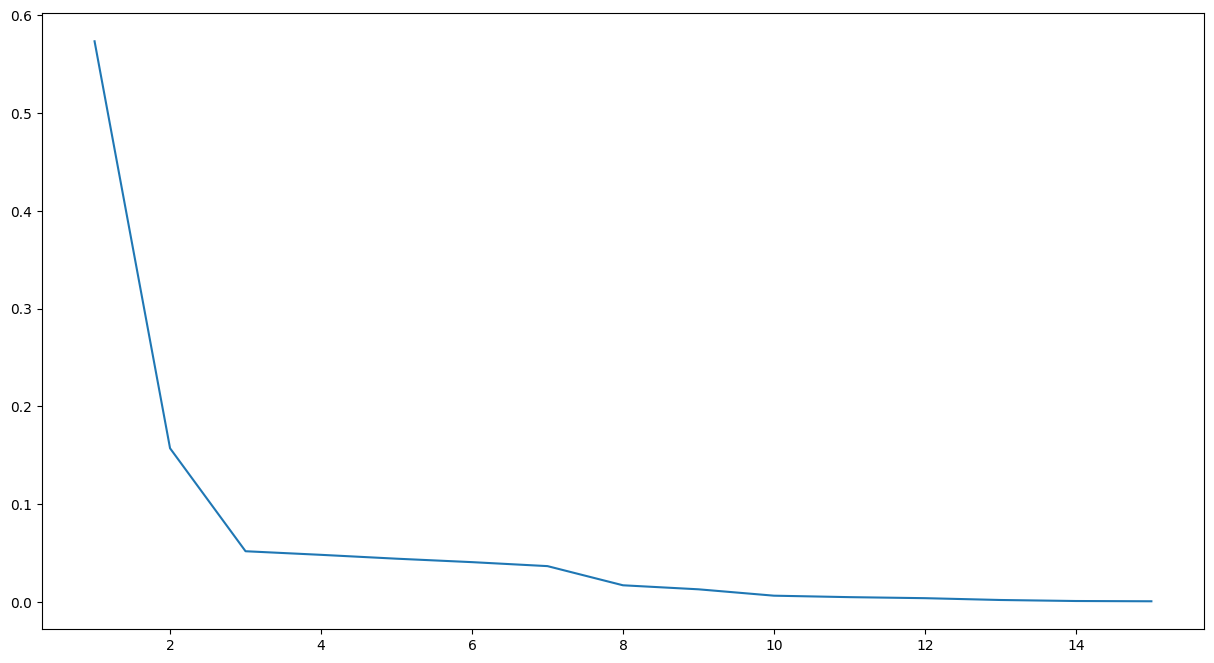

In [11]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(pca.n_components_) + 1, pca.explained_variance_ratio_)

### Fitting the base model

In [12]:
lr_base = LogisticRegression()

lr_base.fit(X_train_transform, y_train)

LogisticRegression()

In [13]:
y_pred = lr_base.predict(X_test_transform)

In [14]:
print("Accuracy of the base model: ", round(accuracy_score(y_test, y_pred), 2))

Accuracy of the base model:  0.86


In [15]:
print("Classification report of the base model: \n\n", classification_report(y_test, y_pred))

Classification report of the base model: 

               precision    recall  f1-score   support

         0.0       0.93      0.82      0.87       337
         1.0       0.80      0.92      0.86       261

    accuracy                           0.86       598
   macro avg       0.86      0.87      0.86       598
weighted avg       0.87      0.86      0.87       598



### Plotting the Confusion Matrix

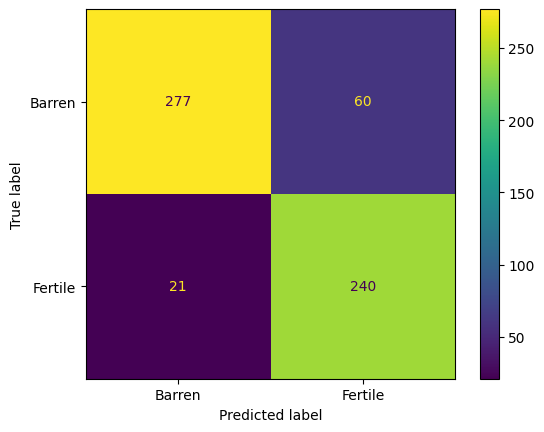

In [16]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot()

#### The model performance is average as it can be observed that False Positives (FP) and False Negatives (FN) are huge.

### Hyper-Parameter Tuning

### Grid Search Optimization with stratified K-fold Cross Validation

In [17]:
Stratified_kf = StratifiedKFold(n_splits=10, shuffle=True)

In [18]:
param_grid = {
                'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                'dual': [True, False],
                'C': [0, 0.5, 1],
                'fit_intercept': [True, False],
                'class_weight': ['balanced'],
                'solver': ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky'],
                'max_iter': [100, 500, 1000],
                'n_jobs': [-1]
    
             }

In [19]:
clf = GridSearchCV(estimator = LogisticRegression(), param_grid=param_grid, scoring='accuracy', n_jobs=-1,
                   cv = Stratified_kf, return_train_score=True, verbose=10)

In [20]:
clf.fit(X_train_transform, y_train)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits
[CV 8/10; 1/576] START C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l1, solver=liblinear
[CV 8/10; 1/576] END C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l1, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 7/10; 8/576] START C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l2, solver=newton-cholesky
[CV 7/10; 8/576] END C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l2, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 8/10; 8/576] START C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l2, solver=newton-cholesky
[CV 8/10; 8/576] END C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l2, solver=newton-cholesky;, s

[CV 3/10; 7/576] END C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l2, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 7/576] START C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l2, solver=newton-cg
[CV 4/10; 7/576] END C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l2, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 12/576] START C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=elasticnet, solvel time=   0.0s
[CV 3/10; 42/576] START C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=lbfgs
[CV 3/10; 42/576] END C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 42/576] S

[CV 1/10; 120/576] END C=0, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=l2, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 120/576] START C=0, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=l2, solver=newton-cholesky
ore=(train=nan, test=nan) total time=   0.0s
[CV 6/10; 116/576] START C=0, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=l1, solver=newton-cholesky
[CV 6/10; 116/576] END C=0, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 7/10; 116/576] START C=0, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=l1, solver=newton-cholesky
[CV 7/10; 116/576] END C=0, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=l1, solver=newton-ch

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

 max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs
[CV 1/10; 274/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 274/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs
[CV 2/10; 274/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 6/10; 167/576] START C=0, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l2, solver=newton-cg
[CV 6/10; 167/576] END C=0, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l2, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 7/10; 167/576] START C=0, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, pe

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

[CV 1/10; 135/576] END C=0, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 135/576] START C=0, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=newton-cg
[CV 2/10; 135/576] END C=0, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 135/576] START C=0, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=newton-cg
[CV 3/10; 135/576] END C=0, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 135/576] START C=0, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=newton-cg
[CV 4/10; 135/576] 

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_j

[CV 2/10; 226/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 226/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs
[CV 3/10; 226/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 226/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs
[CV 4/10; 226/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10; 226/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs
[CV 5/10; 226/576] END C=0.5, class_w

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/pyt

[CV 3/10; 286/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 286/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs
[CV 4/10; 286/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10; 286/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs
[CV 5/10; 286/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 6/10; 286/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs
[CV 6/10; 286/576] 

eep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search

END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 7/10; 286/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs
[CV 7/10; 286/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 8/10; 286/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs
[CV 8/10; 286/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 9/10; 286/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs
[CV 9/10; 286/576] END C=0.5, class_we

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

1000, n_jobs=-1, penalty=l2, solver=newton-cg
[CV 6/10; 327/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=newton-cg;, score=(train=0.834, test=0.841) total time=   0.0s
[CV 7/10; 327/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=newton-cg
[CV 7/10; 327/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=newton-cg;, score=(train==balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=newton-cholesky
[CV 7/10; 276/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 8/10; 276/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=newton-cholesky
[CV 8/10; 276/576

ot 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/

[CV 9/10; 283/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 10/10; 283/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cg
[CV 10/10; 283/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/10; 284/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky
[CV 1/10; 284/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 284/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

, max_iter=100, n_jobs=-1, penalty=l2, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 8/10; 392/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l2, solver=newton-cholesky
[CV 8/10; 392/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l2, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 9/10; 392/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l2, solver=newton-cholesky
[CV 9/10; 392/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l2, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 10/10; 392/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l2, solver=newton-cholesky
[CV 10/10; 392/576] END C=1, class_weight=balanced, dual=True, fit_interce

[CV 2/10; 396/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 396/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky
[CV 3/10; 396/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 396/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky
[CV 4/10; 396/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10; 396/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n


/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/py

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

ain=nan, test=nan) total time=   0.0s
[CV 3/10; 414/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=none, solver=lbfgs
[CV 3/10; 414/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=none, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 414/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=none, solver=lbfgs
[CV 4/10; 414/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=none, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10; 414/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=none, solver=lbfgs
[CV 5/10; 414/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=none, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 6

/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penal

[CV 6/10; 377/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 7/10; 377/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=liblinear
[CV 7/10; 377/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 8/10; 377/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=liblinear
[CV 8/10; 377/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 9/10; 377/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

iter=100, n_jobs=-1, penalty=l2, solver=liblinear
[CV 2/10; 437/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear;, score=(train=0.743, test=0.724) total time=   0.0s
[CV 3/10; 437/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear
[CV 3/10; 437/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear;, score=(train=0.742, test=0.757) total time=   0.0s
[CV 1/10; 419/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 419/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l1, solver=newton-cg
[CV 2/10; 419/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1

/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3

8/10; 422/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=lbfgs
[CV 8/10; 422/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 9/10; 422/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=lbfgs
[CV 9/10; 422/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 10/10; 422/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=lbfgs
[CV 10/10; 422/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/10; 423/576] START C=1, class_weight=balanced

s.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line S

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #8. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

[CV 3/10; 382/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs;, score=(train=0.766, test=0.791) total time=   0.0s
[CV 4/10; 382/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs
[CV 4/10; 382/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs;, score=(train=0.763, test=0.799) total time=   0.0s
[CV 5/10; 382/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs
[CV 5/10; 382/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs;, score=(train=0.771, test=0.741) total time=   0.0s
[CV 6/10; 382/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=lbfgs
[

/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' i

[CV 4/10; 437/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear
[CV 4/10; 437/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear;, score=(train=0.740, test=0.762) total time=   0.0s
[CV 5/10; 437/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear
[CV 5/10; 437/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear;, score=(train=0.741, test=0.728) total time=   0.0s
[CV 6/10; 437/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear
[CV 6/10; 437/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear;, score=(train=0.740, test=0.753) total time=   0.0s
[CV 7/10; 437

[CV 6/10; 453/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l2, solver=liblinear;, score=(train=0.740, test=0.753) total time=   0.2s
[CV 7/10; 453/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l2, solver=liblinear
[CV 7/10; 453/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l2, solver=liblinear;, score=(train=0.742, test=0.728) total time=   0.2s
[CV 8/10; 453/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l2, solver=liblinear
[CV 8/10; 453/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l2, solver=liblinear;, score=(train=0.742, test=0.732) total time=   0.1s
[CV 9/10; 453/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l2, solver=liblinear
[CV 9/10; 453

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings

iter=100, n_jobs=-1, penalty=none, solver=newton-cholesky
[CV 6/10; 544/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=newton-cholesky;, score=(train=0.763, test=0.778) total time=   0.0s
[CV 7/10; 544/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=newton-cholesky
[CV 7/10; 544/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=newton-cholesky;, score=(train=0.769, test=0.774) total time=   0.0s
[CV 8/10; 544/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=newton-cholesky
[CV 8/10; 544/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=newton-cholesky;, score=(train=0.764, test=0.774) total time=   0.0s
[CV 9/10; 544/576] START C=1, class_weight=balanc

[CV 10/10; 542/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=lbfgs;, score=(train=0.765, test=0.774) total time=   0.0s
[CV 1/10; 543/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=newton-cg
[CV 1/10; 543/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=newton-cg;, score=(train=0.773, test=0.732) total time=   0.0s
[CV 2/10; 543/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=newton-cg
[CV 2/10; 543/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=newton-cg;, score=(train=0.774, test=0.745) total time=   0.0s
[CV 3/10; 543/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=newton-c

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_m

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


[CV 3/10; 532/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l1, solver=newton-cholesky
[CV 3/10; 532/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 532/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l1, solver=newton-cholesky
[CV 4/10; 532/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10; 532/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l1, solver=newton-cholesky
[CV 5/10; 532/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l1, solver=newton-cholesky;, score=(train=nan, test=nan) to

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_m

[CV 9/10; 490/576] START C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=lbfgs
[CV 9/10; 490/576] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 10/10; 490/576] START C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=lbfgs
[CV 10/10; 490/576] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/10; 491/576] START C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cg
[CV 1/10; 491/576] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0, 0.5, 1], 'class_weight': ['balanced'],
                         'dual': [True, False], 'fit_intercept': [True, False],
                         'max_iter': [100, 500, 1000], 'n_jobs': [-1],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['liblinear', 'lbfgs', 'newton-cg',
                                    'newton-cholesky']},
             return_train_score=True, scoring='accuracy', verbose=10)

In [21]:
clf.best_estimator_

LogisticRegression(C=0.5, class_weight='balanced', n_jobs=-1, penalty='none')

In [22]:
clf.best_params_

{'C': 0.5,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'max_iter': 100,
 'n_jobs': -1,
 'penalty': 'none',
 'solver': 'lbfgs'}

In [23]:
print("Best accuracy obtained: ", round(clf.best_score_, 2))

Best accuracy obtained:  0.87


### Predicting the test set outcomes over best parameters

In [24]:
best_model_gridsearch = LogisticRegression(**clf.best_params_)

In [25]:
best_model_gridsearch.fit(X_train_transform, y_train)

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.5, class_weight='balanced', n_jobs=-1, penalty='none')

In [26]:
y_pred_best = best_model_gridsearch.predict(X_test_transform)

In [27]:
print("Accuracy of the test set on tuned model: ", round(accuracy_score(y_test, y_pred_best), 2))

Accuracy of the test set on tuned model:  0.88


In [28]:
print("Classification report of test set on the tuned model: \n\n", classification_report(y_test, y_pred_best))

Classification report of test set on the tuned model: 

               precision    recall  f1-score   support

         0.0       0.96      0.83      0.89       337
         1.0       0.81      0.95      0.88       261

    accuracy                           0.88       598
   macro avg       0.88      0.89      0.88       598
weighted avg       0.89      0.88      0.88       598



### Plotting the Confusion Matrix

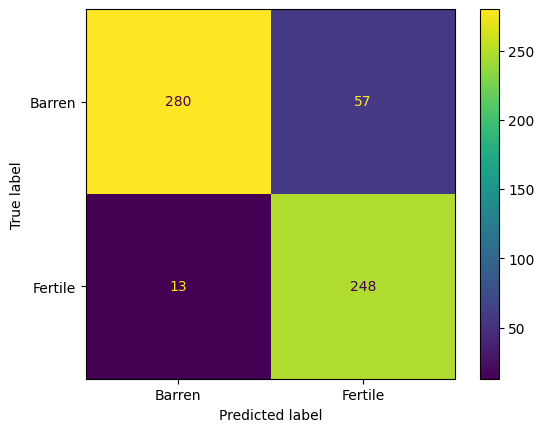

In [29]:
cm = confusion_matrix(y_test, y_pred_best)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot()

### Analysis on K-means Imputed and Outlier Handled dataset

In [30]:
df2 = pd.read_csv("./data_outliers_handled_kmeans_imputed.csv")

In [31]:
df2.head()

Unnamed: 0  age_ma  Feature     Ti     La      Ce     Pr       Nd  \
0           0   222.0      0.0   7.88  0.050  10.500  0.050  4.25000   
1           1   222.0      0.0  10.90  1.555  61.505  0.725  7.74125   
2           2   222.0      0.0   6.00  0.020  25.100  0.300  4.41000   
3           3   222.0      0.0   9.06  0.280  12.000  0.070  1.88000   
4           4   222.0      0.0   4.93  0.070  16.500  0.150  2.32000   

         Sm       Eu  ...         Dy        Ho         Er       Tm       Yb  \
0  11.60000  1.99000  ...  259.21625  106.1375  437.54375  97.8675  936.725   
1  12.56125  2.64375  ...  259.21625  106.1375  437.54375  97.8675  936.725   
2  12.56125  2.30000  ...  259.21625  106.1375  437.54375  97.8675  936.725   
3   5.08000  1.01000  ...  194.00000   83.0000  356.00000  89.5000  762.000   
4   8.23000  1.52000  ...  257.00000  106.1375  437.54375  97.8675  936.000   

          Lu           Y       Hf      U     Th  
0  172.63875  2737.00000  12390.0  305.0  134.0  
1  172.63875  2804.03875  12591.0  503.0  272.0  
2  172.63875  2804.03875  12724.0  639.0  414.0  
3  144.00000  1832.00000  12894.0  308.0  127.0  
4  171.00000  2355.00000  12535.0  348.0  155.0  

[5 rows x 22 columns]

In [32]:
df2.drop('Unnamed: 0', axis=1, inplace=True)

In [33]:
df2.sample(5)

age_ma  Feature     Ti    La      Ce    Pr    Nd    Sm    Eu     Gd  \
1353   129.0      0.0   6.00  0.32  61.505  0.11  3.46  7.31  2.46  41.02   
78     113.0      0.0   9.17  1.10   7.530  0.37  0.62  1.97  0.88  12.22   
1750    41.0      1.0   3.64  0.08  36.000  0.06  0.97  2.08  1.12  12.20   
34     109.0      0.0   9.54  0.09   7.660  0.10  1.81  4.41  0.80  27.04   
2289   370.0      1.0  11.48  0.14   6.050  0.10  0.80  1.87  0.52  12.03   

      ...      Dy     Ho      Er     Tm       Yb         Lu        Y  \
1353  ...  183.70  71.31  373.08  89.30  936.725  172.63875  2476.00   
78    ...   79.19  31.70  170.30  46.20  569.490  100.74000  1022.70   
1750  ...   51.10  20.20   98.30  23.10  247.000   52.80000   679.00   
34    ...  144.69  53.66  255.38  60.67  641.900   94.81000  1519.55   
2289  ...   50.87  19.81   98.31  24.08  248.290   43.53000   606.05   

               Hf       U        Th  
1353  15267.18625  986.00  701.7125  
78    10554.72000   89.09   58.9200  
1750   8928.00000  673.00  269.0000  
34    10057.02000  119.35  106.5400  
2289   8945.70000   52.53   26.9500  

[5 rows x 21 columns]

In [34]:
X = df2.drop('Feature', axis=1).values
y = df2.Feature.values

### Splitting the dataset

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Scaling the data using Standard Scaler

In [36]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### PCA

In [37]:
pca = PCA(n_components=15)

X_train_transform = pca.fit_transform(X_train_scaled)
X_test_transform = pca.transform(X_test_scaled)

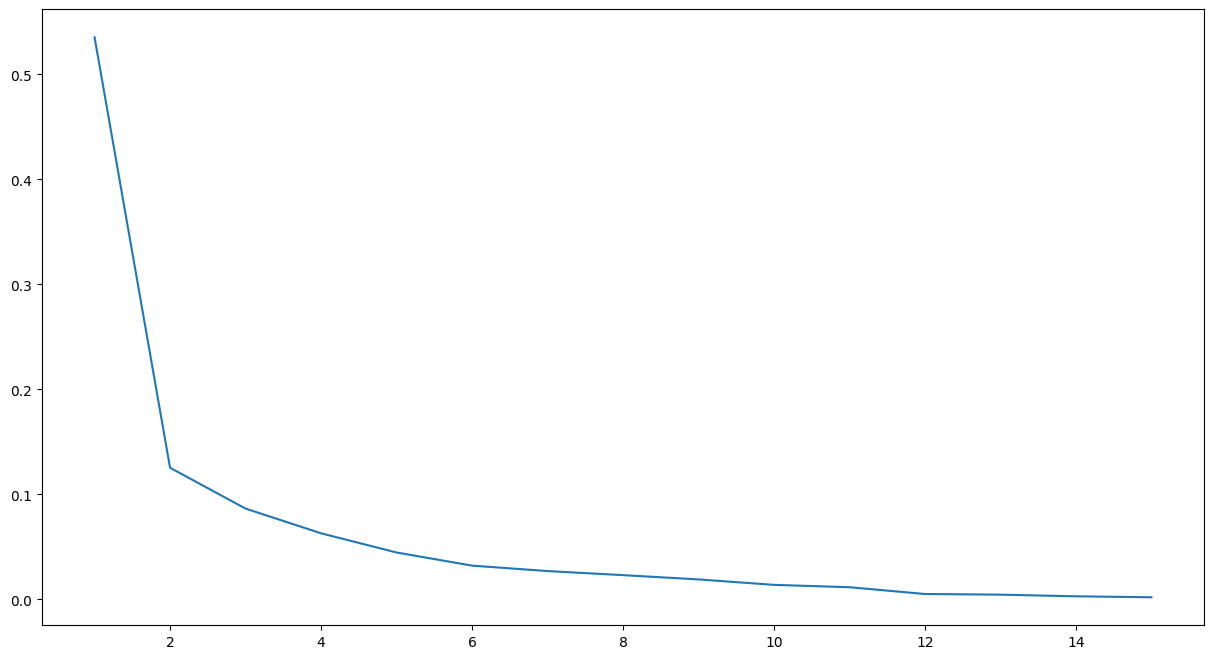

In [38]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(pca.n_components_) + 1, pca.explained_variance_ratio_)

### Fitting the base model

In [39]:
lr_base = LogisticRegression()

lr_base.fit(X_train_transform, y_train)

LogisticRegression()

In [40]:
y_pred = lr_base.predict(X_test_transform)

In [41]:
print("Accuracy of the base model: ", round(accuracy_score(y_test, y_pred), 2))

Accuracy of the base model:  0.88


In [42]:
print("Classification report of the base model: \n\n", classification_report(y_test, y_pred))

Classification report of the base model: 

               precision    recall  f1-score   support

         0.0       0.93      0.85      0.89       328
         1.0       0.83      0.93      0.88       270

    accuracy                           0.88       598
   macro avg       0.88      0.89      0.88       598
weighted avg       0.89      0.88      0.88       598



### Plotting the Confusion Matrix

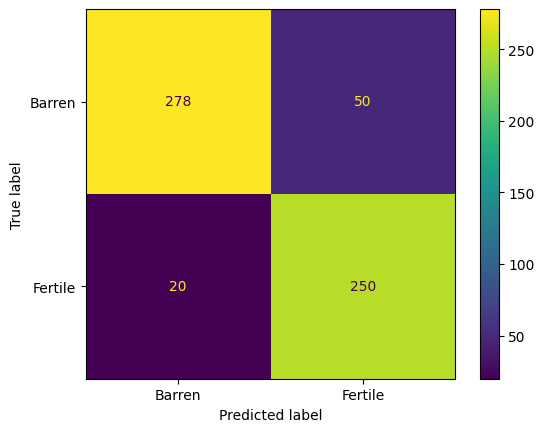

In [43]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot()

### Hyper-Parameter Tuning

### Grid Search Optimization with stratified K-fold Cross Validation

In [44]:
Stratified_kf = StratifiedKFold(n_splits=10, shuffle=True)

In [45]:
param_grid = {
                'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                'dual': [True, False],
                'C': [0, 0.5, 1],
                'fit_intercept': [True, False],
                'class_weight': ['balanced'],
                'solver': ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky'],
                'max_iter': [100, 500, 1000],
                'n_jobs': [-1]
    
             }

In [46]:
clf = GridSearchCV(estimator = LogisticRegression(), param_grid=param_grid, scoring='accuracy', n_jobs=-1,
                   cv = Stratified_kf, return_train_score=True, verbose=10)

In [47]:
clf.fit(X_train_transform, y_train)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits
[CV 2/10; 546/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 546/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l1, solver=lbfgs
[CV 3/10; 546/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 546/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l1, solver=lbfgs
[CV 4/10; 546/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10; 546/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, pen

[CV 1/10; 572/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky
[CV 1/10; 572/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 572/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky
[CV 2/10; 572/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 572/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky
[CV 3/10; 572/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, s

[CV 7/10; 43/576] START C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cg
[CV 7/10; 43/576] END C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 8/10; 43/576] START C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cg
[CV 8/10; 43/576] END C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=new, penalty=none, solver=newton-cg
[CV 5/10; 47/576] END C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=none, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 6/10; 47/576] START C=0, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=none, solver=newton-cg
[CV 6/10; 47/576] 

[CV 8/10; 80/576] END C=0, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=none, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 9/10; 80/576] START C=0, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=none, solver=newton-cholesky
[CV 9/10; 80/576] END C=0, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=none, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 10/10; 80/576] START C=0, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, pe 63/576] START C=0, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=newton-cg
[CV 6/10; 63/576] END C=0, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 7/10; 63/576] START C=0, class_wei

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

=True, max_iter=500, n_jobs=-1, penalty=elasticnet, solver=lbfgs
[CV 1/10; 218/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 218/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=elasticnet, solver=lbfgs
[CV 2/10; 218/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=elasticnet, solver=obs=-1, penalty=none, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 7/10; 191/576] START C=0, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=newton-cg
[CV 7/10; 191/576] END C=0, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 8/10; 191/576] START C=0, class_weight=

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(

[CV 10/10; 284/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky
[CV 10/10; 284/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/10; 285/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=liblinear
[CV 1/10; 285/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 285/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=liblinear
[CV 2/10; 285/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=none, solver=liblinear;, score=(train=nan

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(

ntercept=True, max_iter=100, n_jobs=-1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 195/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l1, solver=newton-cg
[CV 4/10; 195/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10; 195/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l1, solver=newton-cg
[CV 5/10; 195/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 6/10; 195/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=l1, solver=newton-cg
[CV 6/10; 195/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=True, max_

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(

[CV 2/10; 251/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 251/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cg
[CV 3/10; 251/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 251/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cg
[CV 4/10; 251/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10; 251/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, pe

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 

[CV 1/10; 263/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l2, solver=newton-cg
[CV 1/10; 263/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l2, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 263/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l2, solver=newton-cg
[CV 2/10; 263/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l2, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 263/576] START C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l2, solver=newton-cg
[CV 3/10; 263/576] END C=0.5, class_weight=balanced, dual=True, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l2, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 263

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To k

C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 307/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=l1, solver=newton-cg
[CV 3/10; 307/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 307/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=l1, solver=newton-cg
[CV 4/10; 307/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10; 307/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=l1, solver=newton-cg
[CV 5/10; 307/576] END C=0.5, class_

[CV 7/10; 347/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 8/10; 347/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cg
[CV 8/10; 347/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 9/10; 347/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cg
[CV 9/10; 347/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 10/10; 347/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs

223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:12

4/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 10/10; 354/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l1, solver=lbfgs
[CV 10/10; 354/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/10; 355/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l1, solver=newton-cg
[CV 1/10; 355/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 355/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=500, n_jobs=-1, penalty=l1, solver=newton-cg
[CV 2/10; 355/576] END C=0.5,

conda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the p

[CV 1/10; 325/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=liblinear;, score=(train=0.869, test=0.866) total time=   0.0s
[CV 2/10; 325/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=liblinear
[CV 2/10; 325/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=liblinear;, score=(train=0.868, test=0.870) total time=   0.0s
[CV 3/10; 325/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=liblinear
[CV 3/10; 325/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=liblinear;, score=(train=0.872, test=0.845) total time=   0.0s
[CV 4/10; 325/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=libli

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Go

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

[CV 3/10; 475/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cg
[CV 3/10; 475/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 475/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cg
[CV 4/10; 475/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10; 475/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cg
[CV 5/10; 475/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=elasticnet, solver=newton-cg;, score=(train=nan, 

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does n

[CV 10/10; 440/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=l2, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/10; 441/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=liblinear
[CV 1/10; 441/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 441/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=liblinear
[CV 2/10; 441/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 441/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=elastic

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

[CV 8/10; 445/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=liblinear
[CV 8/10; 445/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 9/10; 445/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=liblinear
[CV 9/10; 445/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 10/10; 445/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=liblinear
[CV 10/10; 445/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/10; 4

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: Futu

[CV 4/10; 370/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs
[CV 4/10; 370/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10; 370/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs
[CV 5/10; 370/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 6/10; 370/576] START C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs
[CV 6/10; 370/576] END C=0.5, class_weight=balanced, dual=False, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 9/10; 485/576] START 

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: User

ight=balanced, dual=False, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=lbfgs
[CV 4/10; 490/576] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, n_jobs=-1, penalty=elasticnet, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/10; 421/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=liblinear
[CV 1/10; 421/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=liblinear;, score=(train=0.868, test=0.870) total time=   0.1s
[CV 2/10; 421/576] START C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=liblinear
[CV 2/10; 421/576] END C=1, class_weight=balanced, dual=True, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=l2, solver=liblinear;, score=(train=0.869, test=0.866) total time=   0.1s
[CV 3/10; 421/576] START C=1, class_weight=bala

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does n

START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=newton-cg
[CV 5/10; 467/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 6/10; 467/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=newton-cg
[CV 6/10; 467/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 7/10; 467/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=newton-cg
[CV 7/10; 467/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l1, solver=newton-cg;, score=(train=nan, test=nan) total time=   0.0s
[CV 8/10; 467/576] START C=1, class_we

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'sol

[CV 1/10; 472/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l2, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 472/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l2, solver=newton-cholesky
[CV 2/10; 472/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l2, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 472/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l2, solver=newton-cholesky
[CV 3/10; 472/576] END C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l2, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 472/576] START C=1, class_weight=balanced, dual=True, fit_intercept=False, max_iter=1000, n_jobs=-1, penalty=l2, solver

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_m

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0, 0.5, 1], 'class_weight': ['balanced'],
                         'dual': [True, False], 'fit_intercept': [True, False],
                         'max_iter': [100, 500, 1000], 'n_jobs': [-1],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['liblinear', 'lbfgs', 'newton-cg',
                                    'newton-cholesky']},
             return_train_score=True, scoring='accuracy', verbose=10)

In [48]:
clf.best_estimator_

LogisticRegression(C=0.5, class_weight='balanced', n_jobs=-1, penalty='l1',
                   solver='liblinear')

In [49]:
clf.best_params_

{'C': 0.5,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'max_iter': 100,
 'n_jobs': -1,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [50]:
print("Best accuracy obtained: ", round(clf.best_score_, 2))

Best accuracy obtained:  0.87


### Predicting the test set outcomes over best parameters

In [51]:
best_model_gridsearch = LogisticRegression(**clf.best_params_)

In [52]:
best_model_gridsearch.fit(X_train_transform, y_train)

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


LogisticRegression(C=0.5, class_weight='balanced', n_jobs=-1, penalty='l1',
                   solver='liblinear')

In [53]:
y_pred_best = best_model_gridsearch.predict(X_test_transform)

In [54]:
print("Accuracy of the test set on tuned model: ", round(accuracy_score(y_test, y_pred_best), 2))

Accuracy of the test set on tuned model:  0.88


In [55]:
print("Classification report of test set on tuned model: \n\n", classification_report(y_test, y_pred_best))

Classification report of test set on tuned model: 

               precision    recall  f1-score   support

         0.0       0.95      0.83      0.88       328
         1.0       0.82      0.94      0.88       270

    accuracy                           0.88       598
   macro avg       0.88      0.89      0.88       598
weighted avg       0.89      0.88      0.88       598



### Plotting the Confusion Matrix

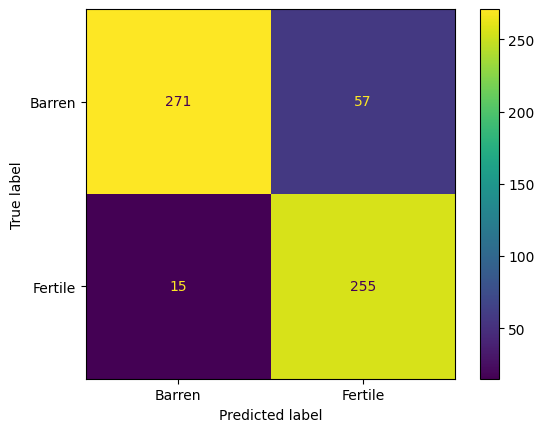

[CV 1/10; 525/576] START C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=none, solver=liblinear
[CV 1/10; 525/576] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=none, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 525/576] START C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=none, solver=liblinear
[CV 2/10; 525/576] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=none, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 525/576] START C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=none, solver=liblinear
[CV 3/10; 525/576] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=1000, n_jobs=-1, penalty=none, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/1

[CV 2/10; 541/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 541/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=liblinear
[CV 3/10; 541/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/10; 541/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=liblinear
[CV 4/10; 541/576] END C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/10; 541/576] START C=1, class_weight=balanced, dual=False, fit_intercept=False, max_iter=100, n_jobs=-1, penalty=none, solver=liblinear
[CV 5/1

[CV 10/10; 508/576] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=elasticnet, solver=newton-cholesky;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/10; 509/576] START C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=none, solver=liblinear
[CV 1/10; 509/576] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=none, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/10; 509/576] START C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=none, solver=liblinear
[CV 2/10; 509/576] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=none, solver=liblinear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/10; 509/576] START C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=500, n_jobs=-1, penalty=none, solver=liblinear


In [56]:
cm = confusion_matrix(y_test, y_pred_best)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot()